In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant custom libraries
from src.eda import data_info
from src.models import AutoencoderTrainer, AnomalyDetector
from src.evaluation import ValidationEvaluation

# Import relevant libraries
import pandas as pd
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime
import numpy as np
import seaborn as sns
import pickle
import tensorflow as tf
import re

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("../data/processed/X_train.feather")
X_train_validate = pd.read_feather("../data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

In [3]:
print("Real-valued variables:", len(real_cols))
print("Binary variables:", len(binary_cols))

Real-valued variables: 9
Binary variables: 55


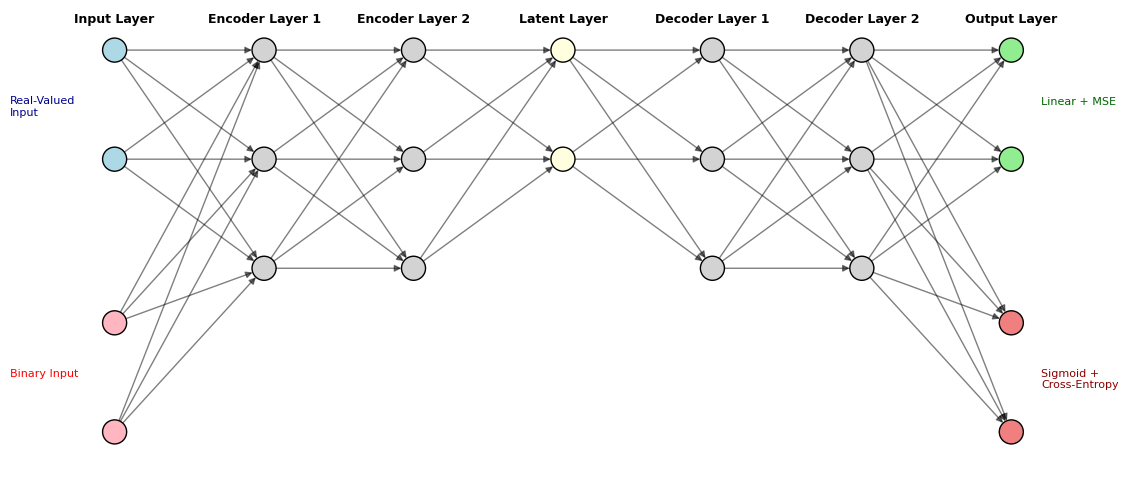

In [ ]:
def draw_colored_annotated_autoencoder_graph():
    G = nx.DiGraph()

    # Define layer sizes
    input_real = 2
    input_bin = 2
    encoder_1 = 3
    encoder_2 = 3
    latent = 2
    decoder_1 = 3
    decoder_2 = 3
    output_real = 2
    output_bin = 2

    # Positions for all nodes
    pos = {}
    node_colors = {}

    def place_layer(start_y, n, x, layer_name, color):
        nodes = []
        for i in range(n):
            name = f"{layer_name}_{i}"
            pos[name] = (x, start_y - i)
            nodes.append(name)
            node_colors[name] = color
        return nodes

    # Layers
    input_real_nodes = place_layer(0, input_real, 0, 'in_real', 'lightblue')
    input_bin_nodes = place_layer(-2.5, input_bin, 0, 'in_bin', 'lightpink')
    enc1_nodes = place_layer(0, encoder_1, 1, 'enc1', 'lightgray')
    enc2_nodes = place_layer(0, encoder_2, 2, 'enc2', 'lightgray')
    latent_nodes = place_layer(0, latent, 3, 'z', 'lightyellow')
    dec1_nodes = place_layer(0, decoder_1, 4, 'dec1', 'lightgray')
    dec2_nodes = place_layer(0, decoder_2, 5, 'dec2', 'lightgray')
    out_real_nodes = place_layer(0, output_real, 6, 'out_real', 'lightgreen')
    out_bin_nodes = place_layer(-2.5, output_bin, 6, 'out_bin', 'lightcoral')

    # Add edges
    def connect_all(src, tgt):
        for s in src:
            for t in tgt:
                G.add_edge(s, t)

    connect_all(input_real_nodes + input_bin_nodes, enc1_nodes)
    connect_all(enc1_nodes, enc2_nodes)
    connect_all(enc2_nodes, latent_nodes)
    connect_all(latent_nodes, dec1_nodes)
    connect_all(dec1_nodes, dec2_nodes)
    connect_all(dec2_nodes, out_real_nodes + out_bin_nodes)

    # Prepare node color list
    color_list = [node_colors[n] for n in G.nodes]

    # Draw
    plt.figure(figsize=(14, 6))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=color_list, edgecolors='black')
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Add layer labels
    layer_labels = {
        0: "Input Layer",
        1: "Encoder Layer 1",
        2: "Encoder Layer 2",
        3: "Latent Layer",
        4: "Decoder Layer 1",
        5: "Decoder Layer 2",
        6: "Output Layer"
    }

    for x, label in layer_labels.items():
        plt.text(x, 0.25, label, horizontalalignment='center', fontsize=9, fontweight='bold')

    # Add activation/loss labels near output
    plt.text(6.2, -0.5, "Linear + MSE", fontsize=8, color='darkgreen')
    plt.text(6.2, -3.1, "Sigmoid +\nCross-Entropy", fontsize=8, color='darkred')

    # Add activation/loss labels near output
    plt.text(-0.7, -0.6, "Real-Valued\nInput", fontsize=8, color='darkblue')
    plt.text(-0.7, -3.0, "Binary Input", fontsize=8, color='red')

    plt.axis('off')
    plt.show()

draw_colored_annotated_autoencoder_graph()

## 1. Test the trainer

Epoch 1 → Train Loss: 15.2961, Val Loss: 11.8177
Epoch 2 → Train Loss: 11.0171, Val Loss: 8.9305
Epoch 3 → Train Loss: 8.7268, Val Loss: 6.8936
Epoch 4 → Train Loss: 7.1447, Val Loss: 5.5036
Epoch 5 → Train Loss: 6.1042, Val Loss: 4.5592
Epoch 6 → Train Loss: 5.3639, Val Loss: 3.8823
Epoch 7 → Train Loss: 4.8048, Val Loss: 3.3821
Epoch 8 → Train Loss: 4.3500, Val Loss: 2.9904
Epoch 9 → Train Loss: 4.0073, Val Loss: 2.6750
Epoch 10 → Train Loss: 3.7356, Val Loss: 2.4232
Epoch 11 → Train Loss: 3.4920, Val Loss: 2.2127
Epoch 12 → Train Loss: 3.2762, Val Loss: 2.0365
Epoch 13 → Train Loss: 3.1030, Val Loss: 1.8809
Epoch 14 → Train Loss: 2.9565, Val Loss: 1.7528
Epoch 15 → Train Loss: 2.8570, Val Loss: 1.6406
Epoch 16 → Train Loss: 2.7388, Val Loss: 1.5413
Epoch 17 → Train Loss: 2.6269, Val Loss: 1.4525
Epoch 18 → Train Loss: 2.5257, Val Loss: 1.3693
Epoch 19 → Train Loss: 2.4582, Val Loss: 1.3014
Epoch 20 → Train Loss: 2.3714, Val Loss: 1.2335
Epoch 21 → Train Loss: 2.2887, Val Loss: 1.173

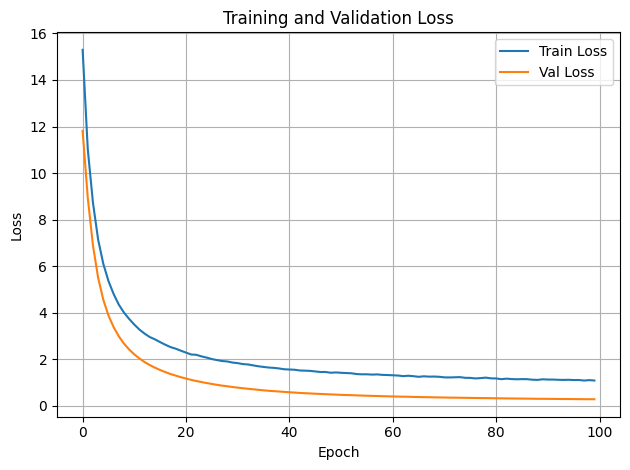

In [ ]:
ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    hidden_dims=[64],
    learning_rate=1.5e-2,
    dropout_rate=0.2,
    verbose=True,
    max_epochs=100,
    plot_losses=True
)
autoencoder = ae.train(X_train, X_train_validate)

## 2. Test the anomaly detector

In [ ]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=ae.lam,
)

# Compute scores
scores = detector._compute_anomaly_scores(X_validate)

# Detect
y_pred = detector._detect(scores, 0.3)

# Evaluate
metrics = detector._evaluate(y_pred, y_validate, scores)
print(metrics)

{'accuracy': 0.7784760408483896, 'precision': 0.4533066132264529, 'recall': 0.4906724511930586, 'f1_score': 0.47125, 'auc': 0.7253691570089347}


## 3. Hyperparameter Tuning

### 3.1. Tuning Implementation

In [ ]:
#! cd ..; python3.11 "scripts/baseline_model.py" --metric auc --n_calls=30 --version 202504131912
#! cd ..; python3.11 "scripts/baseline_model.py" --metric f1_score --n_calls=30 --version 202504130119
#! cd ..; python3.11 "scripts/baseline_model.py" --metric precision --n_calls=30 --version 202504130111
#! cd ..; python3.11 "scripts/baseline_model.py" --metric recall --n_calls=30 --version 202504131715

Best parameters: {'hidden_dims': (64,), 'batch_size': 97, 'dropout_rate': 0.03253732758537381, 'learning_rate': 0.04506605130411295, 'lam': 0.0001, 'gamma': 0.24256548352669904, 'threshold': 0.1562691628932953}
Performance on the validation set: {'accuracy': 0.7809199615955311, 'precision': 0.4623300257258361, 'recall': 0.545770065075922, 'f1_score': 0.5005968961400716, 'auc': 0.7298294743488615}
Performance on the test set: {'accuracy': 0.78144365889849, 'precision': 0.46843481509152035, 'recall': 0.5370449678800856, 'f1_score': 0.5003990422984836, 'auc': 0.7344369942163966}
Best parameters: {'hidden_dims': (64,), 'batch_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.02, 'lam': 0.028457807446378592, 'gamma': 0.35, 'threshold': 11.531513023376464}
Performance on the validation set: {'accuracy': 0.8264816269529546, 'precision': 0.7766143106457243, 'recall': 0.19305856832971802, 'f1_score': 0.3092425295343989, 'auc': 0.7047965761191086}
Performance on the test set: {'accuracy': 0.822

### 3.2. Inspect Convergence of Bayesian Optimization

In [ ]:
metric = "precision"
version = 202504130111
results_df = pd.read_csv(f"../experiments/hyperparam_tune/baseline/bayes_{metric}_{version}.csv")

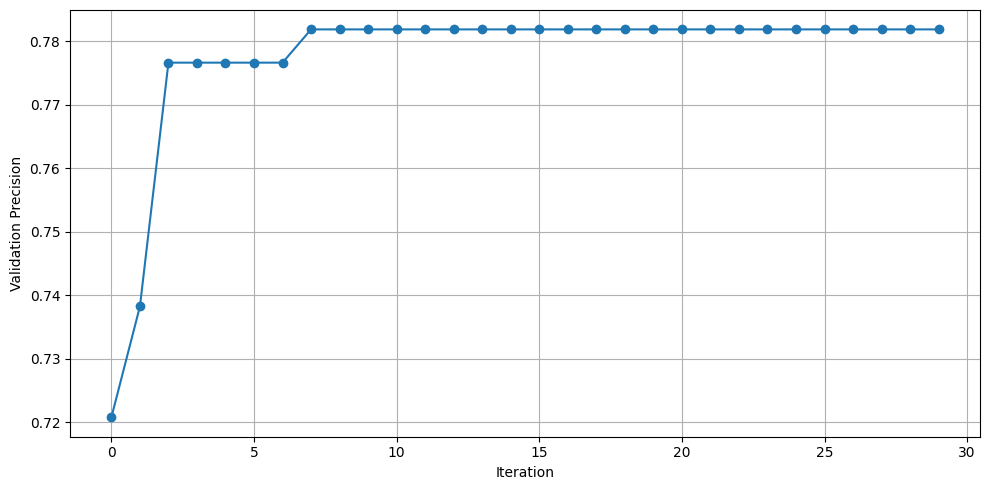

In [ ]:
# Compute cumulative best AUC (i.e., convergence plot)
results_df["best_so_far"] = results_df[metric].cummax()

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df["best_so_far"], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Validation {}".format(metric.title().replace("_", " ")))
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.3. Compare Models Based on Validation Set

In [3]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# Initialize the validation evaluation
valeval = ValidationEvaluation(X_validate, y_validate, real_cols, binary_cols, all_cols, dp_sgd=False)
    
# Read the log file
log_path = "../logs/baseline_tune_log.txt"

# Extract the latest successful Bayesian versions
latest_successful_versions = valeval.extract_latest_successful_bayesian_versions(log_path)
print(latest_successful_versions)

# Evaluate the model performance
eval_results = valeval.evaluate_model_performance(latest_successful_versions)
display(eval_results)

{'202504131912': 'AUC', '202504130111': 'Precision', '202504130119': 'F1 Score', '202504131715': 'Recall'}
Evaluating version 202504131912
Evaluating version 202504130111
Evaluating version 202504130119
Evaluating version 202504131715


,accuracy,precision,recall,f1_score,auc,tuned_by
version,,,,,,
202504131912,0.774112,0.447997,0.528850,0.485078,0.737915,AUC
202504130111,0.826482,0.776614,0.193059,0.309243,0.704797,Precision
202504130119,0.780920,0.462330,0.545770,0.500597,0.729829,F1 Score
202504131715,0.747229,0.414024,0.617354,0.495646,0.743338,Recall


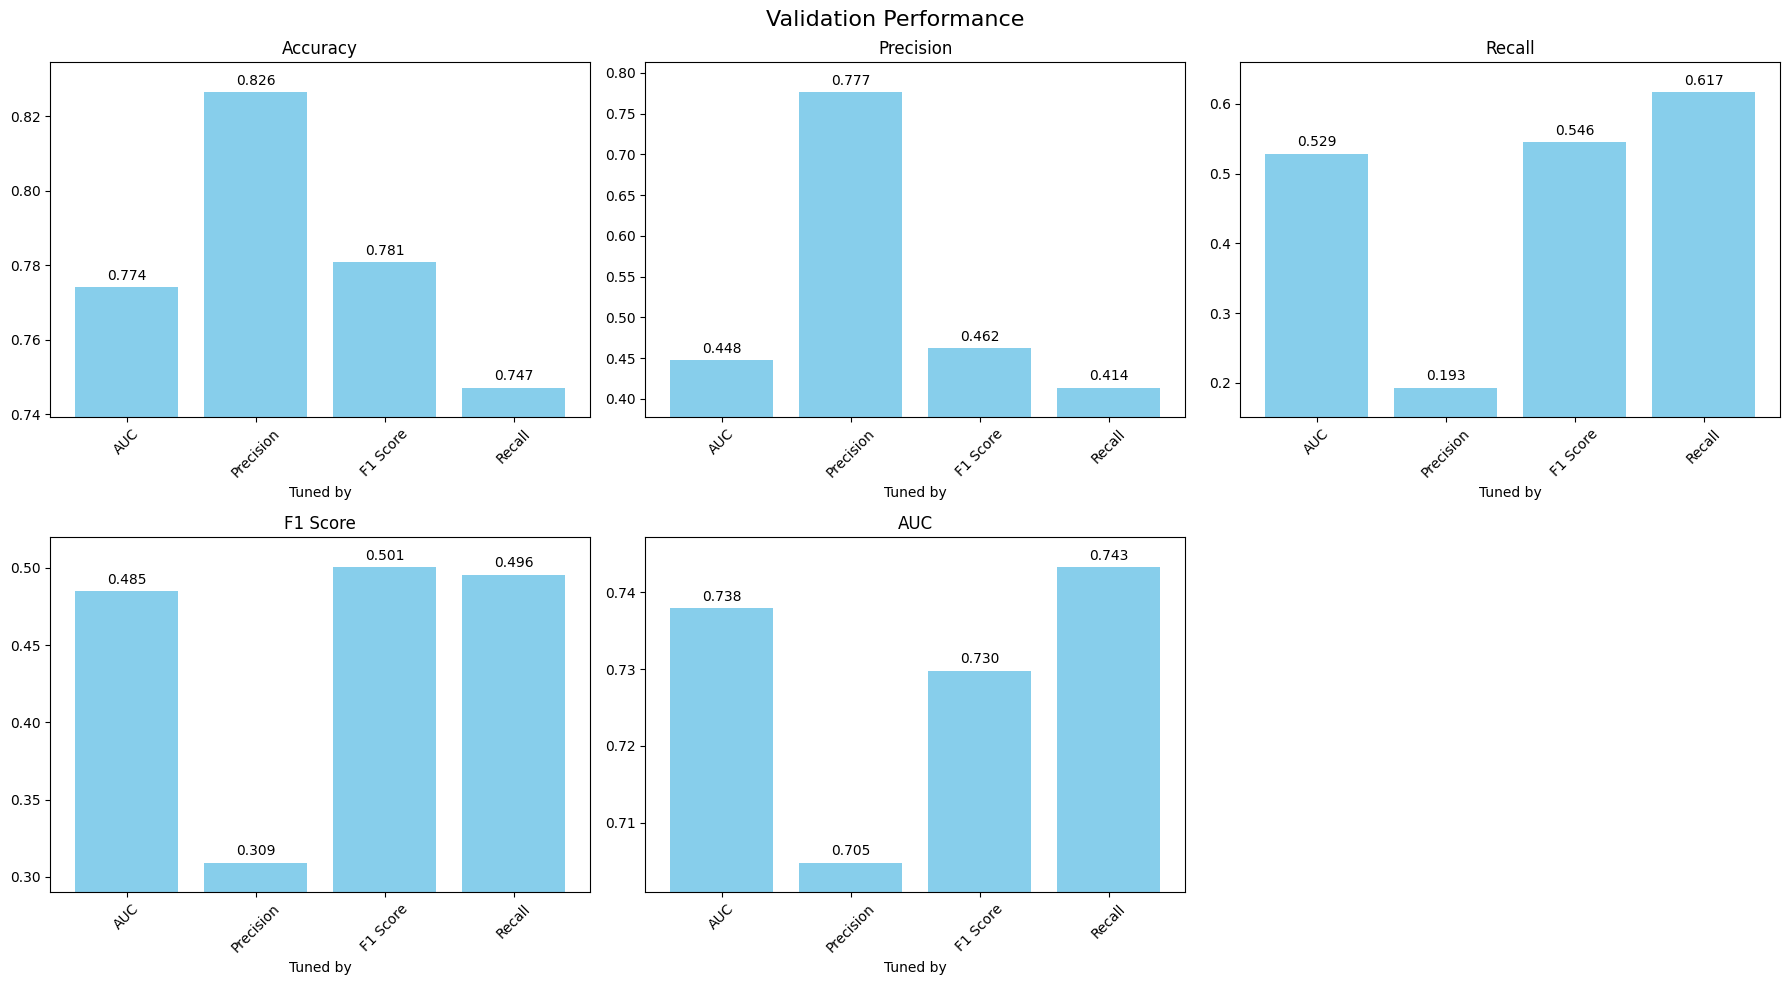

In [4]:
##################################################
## Plot a barplot of the validation performance ##
##################################################

valeval.plot_bar(eval_results, save=False)

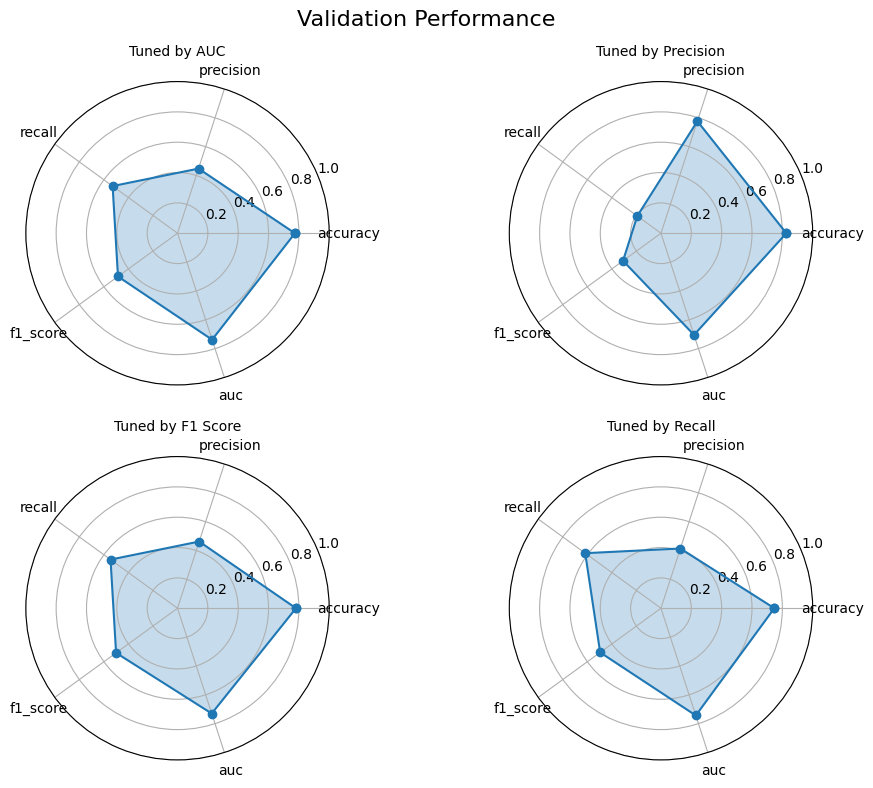

In [5]:
#####################################################
## Plot a radar plot of the validation performance ##
#####################################################
 
valeval.plot_radar(eval_results)

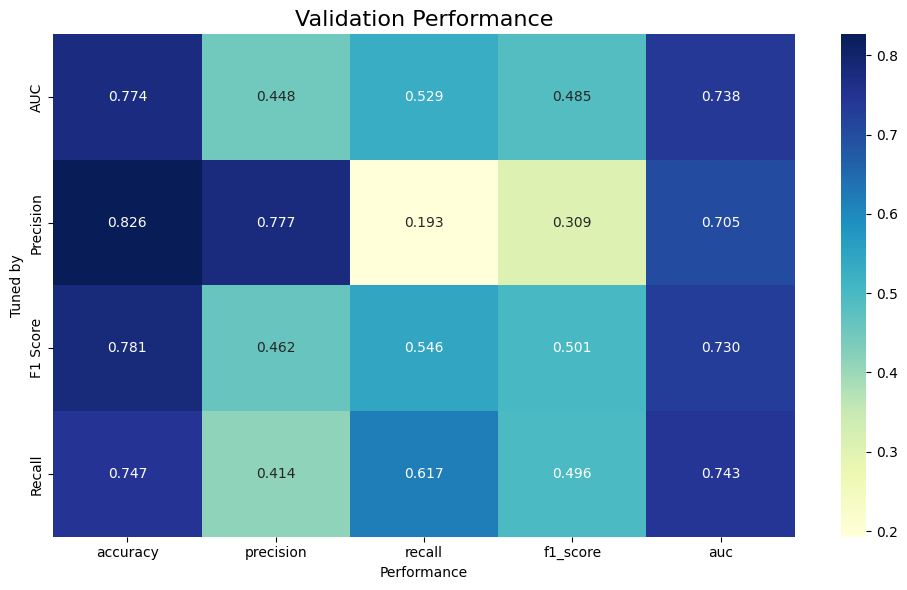

In [6]:
##################################################
## Plot a heatmap of the validation performance ##
##################################################
 
valeval.plot_heatmap(eval_results)